In [14]:
import os
import re

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.util import ngrams
from collections import Counter
import gensim
from gensim import corpora, models

# Ensure NLTK components are downloaded
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\su.osmond\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\su.osmond\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


True

## **Prepare Data**

In [4]:
# Load the datasets
df_user_inputs = pd.read_csv('user_inputs.csv', delimiter=';')
df_labels = pd.read_csv('labels.csv', delimiter=";")

# Remove unnecessary index columns
df_user_inputs.drop(df_user_inputs.columns[0], axis=1, inplace=True)
df_labels.drop(df_labels.columns[0], axis=1, inplace=True)

# Remove classes with < 2 instances (this is only 'no complaints' label with 0 instance so not a big deal)
# We need to do this to split the data later with stratification
df_labels = df_labels.loc[:, (df_labels.sum(axis=0) >= 2)]

# Ensure alignment
assert len(df_labels) == len(df_user_inputs), "Datasets do not align!"

print(df_user_inputs.shape)
df_user_inputs.head(10)

(3974, 1)


,text
0,Er is een teek op mijn been. Ik ben bang dat d...
1,Er is een teek op mijn rug en ik krijg hem er ...
2,Op mijn been zit een teek. Ik heb hem geprobee...
3,Ik heb allergieen
4,huid
5,roodheid
6,schilfering
7,Ik heb wratten onder mijn voet
8,Ik heb gisteren naar het bos geweest en zie nu...
9,Ik voelde iets prikken


In [5]:
print(df_labels.shape)
df_labels.iloc[:, 1:6].head()

(3974, 74)


,Beenklachten,Bloedneus,Misselijkheid en overgeven,Brandwond,Buikpijn
0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0


In [3]:
# Preprocess user input text
# could be better and more advanced
def preprocess_text(text):
    """
    Preprocesses the input text by converting to lowercase and removing special characters.
    Args:
        text (str): The text to preprocess.
    Returns:
        str: The preprocessed text.
    """

    # Convert to lowercase
    text = text.lower()
    # Remove special characters
    text = re.sub(r'\W+', ' ', text)
    return text

df_user_inputs['text'] = df_user_inputs['text'].apply(preprocess_text)

df_user_inputs.head()

,text
0,er is een teek op mijn been ik ben bang dat di...
1,er is een teek op mijn rug en ik krijg hem er ...
2,op mijn been zit een teek ik heb hem geprobeer...
3,ik heb allergieen
4,huid


In [6]:
## Descriptive statistics
num_observations = df_labels.shape[0]
num_classes = df_labels.shape[1]
avg_labels_per_instance = np.round(df_labels.sum(axis=1).mean(), 2)
avg_instances_per_label = np.round(df_labels.sum(axis=0).mean(), 2)

# Create the summary df
summary_df = pd.DataFrame({
    "Statistic": ["Number of observations", "Number of classes",
                  "Average number of labels per instance", "Average number of instances per label"],
    "Value": [num_observations, num_classes, avg_labels_per_instance, avg_instances_per_label]
})

summary_df

,Statistic,Value
0,Number of observations,3974.00
1,Number of classes,74.00
2,Average number of labels per instance,1.22
3,Average number of instances per label,65.31


In [11]:
# Determine model baseline
label_frequencies = df_labels.sum().sort_values(ascending=False)
label_frequencies / df_labels.shape[0]

Huidklachten                            0.088827
Beenklachten                            0.072723
Buikpijn                                0.062154
Oorklachten                             0.052843
Misselijkheid en overgeven              0.037242
                                          ...   
Liesklachten                            0.005033
Tekenbeet                               0.005033
Verdrinking                             0.005033
Verwonding aan de buik                  0.005033
Niet lekker voelen, algehele malaise    0.002516
Length: 74, dtype: float64

We see that if we predict every time the label with the highest frequency (Huidklachten), our model will be correct around 9% of the time. We want our model to perform at least better than this 9% threshold

## **EDA - Labels**

Prevalence of 1 label per user input: 0.84


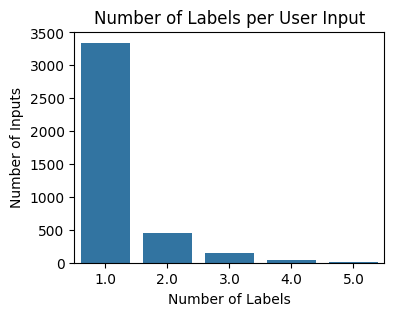

In [7]:
# Count number of labels per user input
num_labels_per_input = df_labels.sum(axis=1)
num_labels_distribution = num_labels_per_input.value_counts().sort_index()

# Display prevalence of single labels
single_label_prevalence = np.round(num_labels_distribution[1] / num_labels_distribution.sum(), 2)
print(f'Prevalence of 1 label per user input: {single_label_prevalence}')

# Plot distribution of the number of labels per input
plt.figure(figsize=(4, 3))
sns.barplot(x=num_labels_distribution.index, y=num_labels_distribution.values)
plt.title('Number of Labels per User Input')
plt.xlabel('Number of Labels')
plt.ylabel('Number of Inputs')
plt.xticks(range(len(num_labels_distribution.index)))
plt.show()

**Observation**: Most user inputs (84%) are associated with only 1 label. This implies that the problem might be less complex that a typical multi-label problem due to the predominance of single-label instances. But we still need to thoughtfully handle the multi-label aspect, especailly for the minority cases of multiple labels.

**Implications for next steps:**
- Model selection: A model that is effective in multi-class classification but also capable of handling multi-label instances
- Training strategy: Prevent model to become overly biased towards single-label predictions (e.g. via stratified sampling or tailored losss functions)
- Evaluation strategy: Use combination of metrics that can evaluate performance on both single-label and multi-label instances effectively. E.g. precision, recall, F1 score for individual labels, overall metrics like Hamming loss or exact match ratio

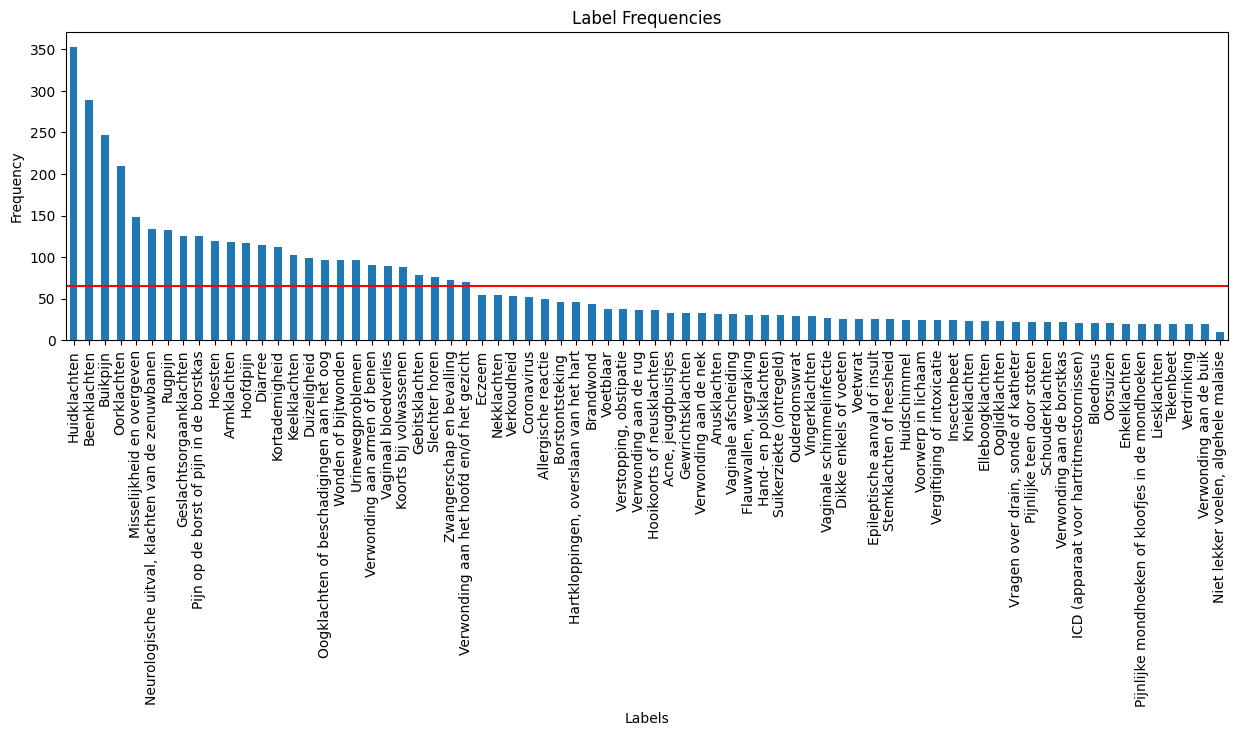

In [8]:
def visualize_frequencies(y, hline=0):
  # Calculate the original frequencies of each label
  label_frequencies_original = df_labels.sum(axis=0).sort_values(ascending=False)

  # Calculate the frequencies
  label_frequencies_new = y.sum(axis=0)

  # Create a df for the frequencies
  df_new_freq = pd.DataFrame(label_frequencies_new, index=df_labels.columns, columns=['frequency'])

  # Sort the frequencies based on the original order
  df_new_freq = df_new_freq.loc[label_frequencies_original.index]

  # Plot the frequencies in descending order based on the original frequencies
  plt.figure(figsize=(15, 4))
  df_new_freq['frequency'].plot(kind='bar')
  plt.title('Label Frequencies')
  plt.xlabel('Labels')
  plt.ylabel('Frequency')
  plt.xticks(rotation=90)
  plt.axhline(y=hline, color='red', linestyle='-')
  plt.show()

visualize_frequencies(df_labels, hline=65)

**Observation:** Seems like there is pretty significant class imbalance. We set a threshold at frequency = 65, which is the mean and also the point where there seems to be a drop-off, so any labels below that we consider a minority class

**Implications for next steps**
- Oversampling rare classes (from frequency < 65) or using class weights in the model
- Choosing evaluation metrics that are less sensitive to class imbalance. E.g. F1 or AUC-ROC, rather than accuracy which can be misleading in imbalanced datasets

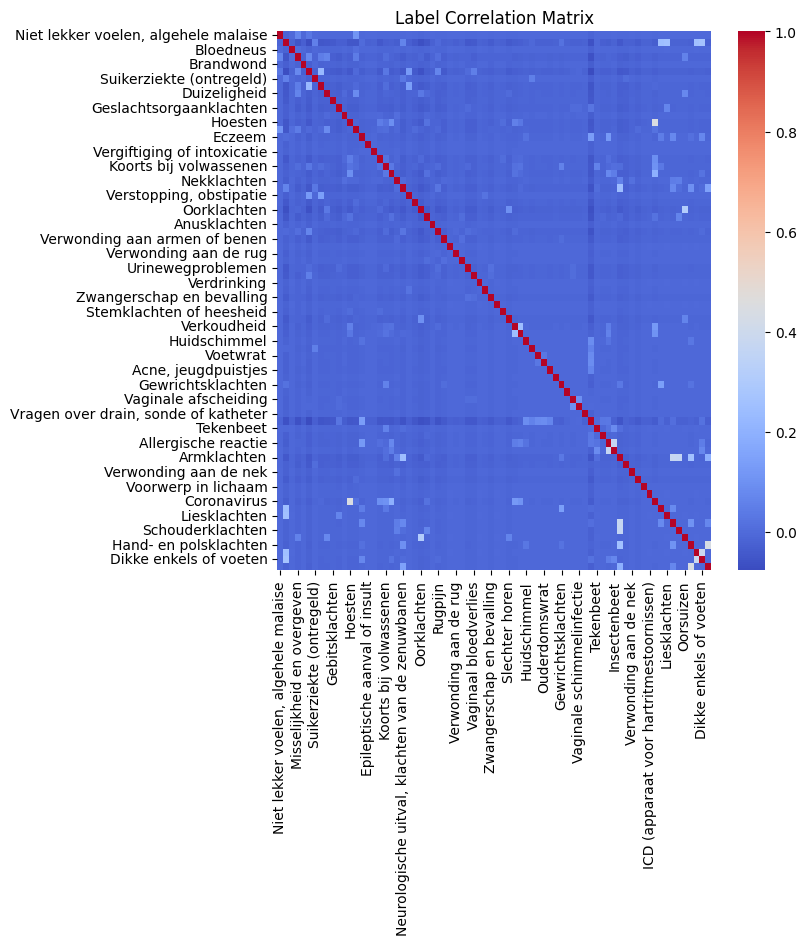

In [9]:
# Calculate correlation between different labels
label_correlation = df_labels.corr()

# Plot the correlation matrix
plt.figure(figsize=(7, 7))
sns.heatmap(label_correlation, annot=False, cmap='coolwarm')
plt.title('Label Correlation Matrix')
plt.show()

**Observation**: Seems like most labels have low correlations with each other, and only a few labels showing moderate correlations.

**Implication for next steps**: No need for special / complex feature engineering or data preprocessing. Priority should then be addressing class imbalance and multi-class/-label

## **EDA - User Inputs**

Here we perform the following analysis and aim:
- **Text length**: Do we need to pad or truncate inputus for model training?
- **Word frequency**: Common themes or terms → feature engineering (creating specific features for frequently occurring terms)
    - N-gram: Common symptom combinations or expressions
    - Contextual understanding: Any specific medical terms or jargons that are frequently mentioned?
- **Topic Modeling (LDA)**: Underlying themes of categories in complaints

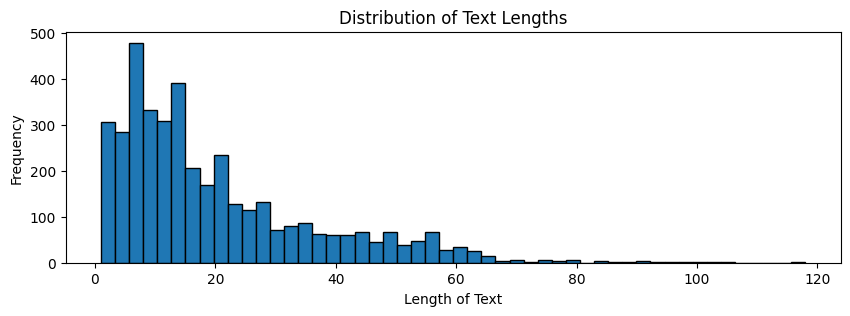

In [15]:
## Text Length Analysis

# Calculate the length of each user input
df_user_inputs['text_length'] = df_user_inputs['text'].apply(lambda x: len(word_tokenize(x)))

# Plot distribution of text lengths
plt.figure(figsize=(10,3))
plt.hist(df_user_inputs['text_length'], bins=50, edgecolor='black')
plt.title('Distribution of Text Lengths')
plt.xlabel('Length of Text')
plt.ylabel('Frequency')
plt.show()

Most text inputs are of moderate length. This suggests that for modeling, we may not need to pad or truncate the input significantly.

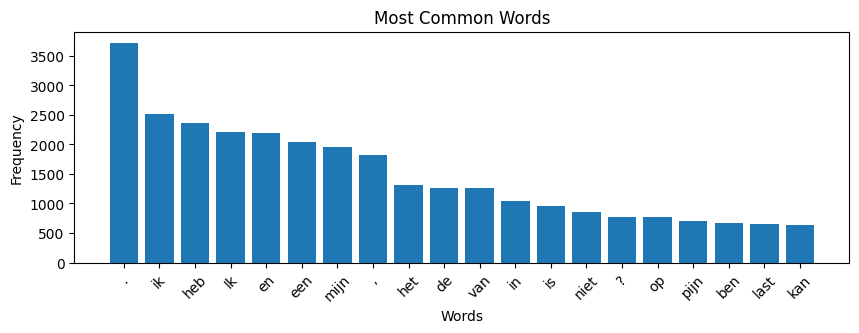

In [16]:
## Word Frequency Analysis

# Tokenize words in each user input
all_words = [word for text in df_user_inputs['text'] for word in word_tokenize(text)]

# Get the most common words
word_freq = Counter(all_words)
common_words = word_freq.most_common(20)

# Plot the most common words
plt.figure(figsize=(10,3))
words, frequencies = zip(*common_words)
plt.bar(words, frequencies)
plt.title('Most Common Words')
plt.xticks(rotation=45)
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.show()

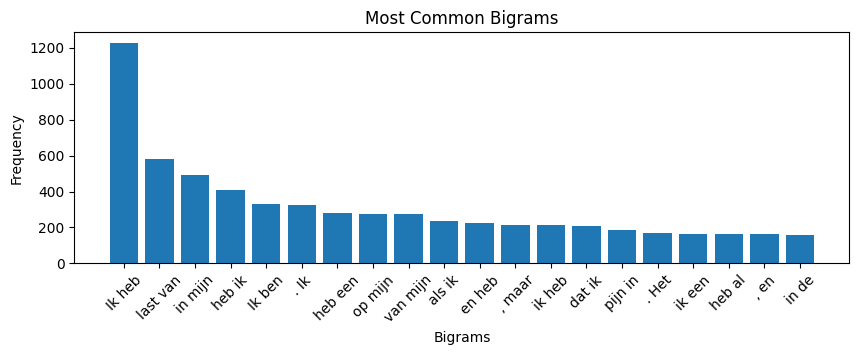

In [17]:
## N-Gram Analysis

# Function to extract n-grams
def extract_ngrams(text, num):
  n_grams = ngrams(word_tokenize(text), num)
  return [' '.join(grams) for grams in n_grams]

# Extract bigrams
bigrams = [bigram for text in df_user_inputs['text'] for bigram in extract_ngrams(text, 2)]
bigram_freq = Counter(bigrams)
common_bigrams = bigram_freq.most_common(20)

# Plot most common bigrams
plt.figure(figsize=(10,3))
bigrams, freqs = zip(*common_bigrams)
plt.bar(bigrams, freqs)
plt.title('Most Common Bigrams')
plt.xticks(rotation=45)
plt.xlabel('Bigrams')
plt.ylabel('Frequency')
plt.show()

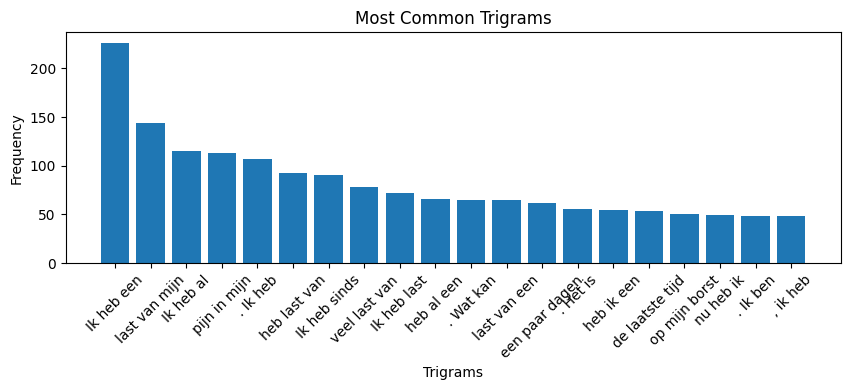

In [18]:
# Extract trigrams
trigrams = [trigram for text in df_user_inputs['text'] for trigram in extract_ngrams(text, 3)]
trigram_freq = Counter(trigrams)
common_trigrams = trigram_freq.most_common(20)

# Plot most common trigrams
plt.figure(figsize=(10,3))
trigrams, freqs = zip(*common_trigrams)
plt.bar(trigrams, freqs)
plt.title('Most Common Trigrams')
plt.xticks(rotation=45)
plt.xlabel('Trigrams')
plt.ylabel('Frequency')
plt.show()

In [19]:
## Topic Modeling

# Tokenize and create a dictionary
tokenized_texts = [word_tokenize(text) for text in df_user_inputs['text']]
dictionary = corpora.Dictionary(tokenized_texts)

# Create a corpus
corpus = [dictionary.doc2bow(text) for text in tokenized_texts]

# Apply LDA
lda_model = gensim.models.ldamodel.LdaModel(corpus, num_topics=5, id2word=dictionary, passes=15)

# Display topics
topics = lda_model.print_topics(num_words=5)
for topic in topics:
  print(topic)

(0, '0.040*"ik" + 0.028*"." + 0.020*"het" + 0.016*"," + 0.016*"de"')
(1, '0.059*"." + 0.029*"een" + 0.028*"mijn" + 0.024*"en" + 0.023*"Ik"')
(2, '0.043*"heb" + 0.042*"ik" + 0.042*"." + 0.035*"Ik" + 0.031*"en"')
(3, '0.054*"mijn" + 0.037*"Ik" + 0.033*"heb" + 0.033*"in" + 0.032*"pijn"')
(4, '0.054*"Mijn" + 0.031*"en" + 0.029*"is" + 0.029*"," + 0.025*"."')
